# Part 1: Data extraction and preparation
In this first section of the code, we’ll employ libraries like geopandas and deep_translator to perform tasks such as opening, modifying, translating, clipping and joining shapefiles. These tools are invaluable for organizing shapefiles efficiently and establishing a common framework for later statistical analysis. 

## Opening, Visualizing and Editing Shapefiles
The first file we will open is the one containing information on the location, number and management type for agricultural plots within our area of interest (AOI). 

<Axes: >

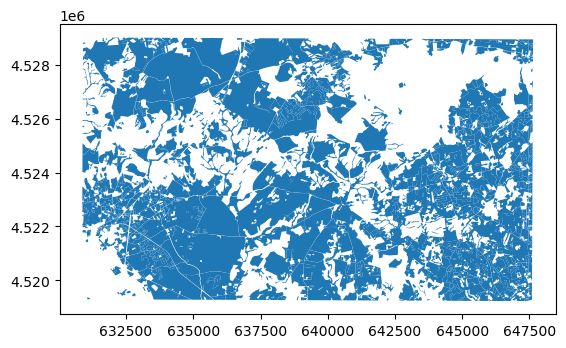

In [6]:
import geopandas as gpd
#load the agricultural land plots and examine the content
gdf_path = "Data_files/AgriculturalPlots.shp"
gdf = gpd.read_file(gdf_path)
gdf.plot()

To reduce computational time, this file has already been clipped to the AOI as its original size was of about 300,000 rows. Let's check the dimensions (i.e., how many rows it contains) of our file now. 

In [4]:
rows, cols = gdf.shape
print('Number of features: {}'.format(rows))

Number of features: 1189


This is a much smaller file and can be handled more easily and quickly.

### Working with Columns
To further reduce the file size we can decide to delete (or drop) any column we might not be interested in. 

#### Listing Columns
To do so, let's fist have a look at the columns contained in the file. 

In [5]:
gdf.columns

Index(['LIVELLO_1', 'LIVELLO_2', 'LIVELLO_3', 'LIVELLO_4', 'CODICE', 'DESC_',
       'SHAPE_AREA', 'SHAPE_LEN', 'r_values', 'geometry'],
      dtype='object')

#### Deleting Columns
This is quite a lot of columns and some of them are not necessary to perform the analysis we are interested in. Deleting them will tidy up our GeoDataFrame and allow the code to run faster.

In [5]:
# Using the result above, identify columns to delete
columns_to_delete = ['LIVELLO_1', 'LIVELLO_2', 'LIVELLO_3', 'LIVELLO_4', 'r_values', 'SHAPE_AREA', 'SHAPE_LEN']
# Drop, i.e. delete the specified columns
gdf.drop(columns=columns_to_delete, inplace=True)
# Save the modified GeoDataFrame back to a shapefile
output_path = 'Data_files/Output_files/updated_Agricultural_plots.shp'
gdf.to_file(output_path)

print(f"Columns {', '.join(columns_to_delete)} have been deleted from the shapefile.")

Columns LIVELLO_1, LIVELLO_2, LIVELLO_3, LIVELLO_4, r_values, SHAPE_AREA, SHAPE_LEN have been deleted from the shapefile.


In [6]:
#let's open the updated shapefile and check the columns now
gdf = gpd.read_file(output_path)
gdf.columns

Index(['CODICE', 'DESC_', 'geometry'], dtype='object')

#### Visualizing Content for specific Columns
We are interested in the column containing information on management type. Let's have a look at its content.

In [7]:
gdf['DESC_']

0                                       vigneti
1                                       vigneti
2                                       vigneti
3                      frutteti e frutti minori
4                      frutteti e frutti minori
                         ...                   
1184                                    uliveti
1185    seminativi semplici in aree non irrigue
1186    seminativi semplici in aree non irrigue
1187    seminativi semplici in aree non irrigue
1188    seminativi semplici in aree non irrigue
Name: DESC_, Length: 1189, dtype: object

### Translating Content
The information is in Italian, we can use the deep_translator tool to translate the column content. The following code defines the function **translate_column** and applies it to each entry in the 'DESC_' column of our GeoDataFrame. 

The defined function does the following:
1. takes a single argument **value**,
2. checks if **value** is **None** or an empty string and returns an empty string in such cases to prevent errors
3. Tries to translate **value** using the initialized translator object
4. if successful, returns the translated value.
5. if an exception occurs during translation, it prints an error message and returns the original **value**.

In [8]:
from  deep_translator import GoogleTranslator

# Initialize the translator
translator = GoogleTranslator(source='it', target='en')

# This defines a function named translate_column that takes a single argument called value
def translate_column(value):
    # to avoid nonetype object errors, the function first checks if the input value is 
    # either None or an empty string ('').
    if value is None or value == '':
        return ''
    try:
        # Attempt to translate the value
        translated_value = translator.translate(value)
        return translated_value
    except Exception as e:
        # If an error occurs, print the error and return the original value
        print(f"Error translating '{value}': {e}")
        return value

# Apply translation to the 'DESC_' column
gdf['DESC_'] = gdf['DESC_'].apply(translate_column)

# Save the GeoDataFrame with the translated column
gdf.to_file('Data_files/Output_files/translated_Agricultural_plots.shp')

# Print a success message (this might take a while to appear depending on the size of the file).
print("The 'DESC_' column has been translated from Italian to English and saved in 'translated_Agricultural_plots.shp'.")

The 'DESC_' column has been translated from Italian to English and saved in 'translated_Agricultural_plots.shp'.


Translation might take a few minutes depending on file size. Once the translation has run, the code should print a success message. To make sure that the code has worked, let's check a few things before starting to use the translated data.

In [15]:
#load the translated shapefile to check that the column has in fact been translated
translated_shapefile_path = 'Data_files/Output_files/translated_Agricultural_plots.shp'
gdf = gpd.read_file(translated_shapefile_path)
gdf.head()

,CODICE,DESC_,geometry
0,221,vineyards,"POLYGON Z ((647468.894 4520416.843 0.000, 6474..."
1,221,vineyards,"POLYGON Z ((640443.620 4528059.830 0.000, 6404..."
2,221,vineyards,"POLYGON Z ((644611.482 4519606.510 0.000, 6445..."
3,222,orchards and minor fruits,"POLYGON Z ((646206.803 4523193.705 0.000, 6462..."
4,222,orchards and minor fruits,MULTIPOLYGON Z (((647587.885 4524979.883 0.000...


In [16]:
#check that the number of rows is still the same after the translation
rows, cols = gdf.shape
print('Number of features: {}'.format(rows))

Number of features: 1189


Once we are happy that the file still contains all the information we need we can proceed with the rest of the data preparation process. 

### Calculating Areas

We want to calculate the area of each individual agricultural plot. First, we should check for any invalid geometries in the file.  The code below checks for invalid geometries and reports if any are found.

In [10]:
invalid = gdf[~gdf['geometry'].is_valid]

if not invalid.empty:
    print(f"Found {len(invalid)} invalid geometries.")
else:
    print("No invalid geometries found.")

Found 6 invalid geometries.


<Axes: >

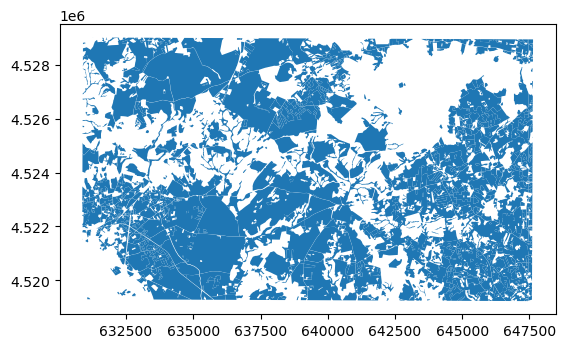

In [11]:
clean = gdf.geometry.buffer(0)
#check we still have the same data
clean.plot()

Before we calculate areas we also want to make sure our shapefile is in the appropriate coordinate system. The code below checks that the CRS is projected and prints a message to inform the user whether the CRS is suitable for calculating areas or if it needs conversion. 

In [17]:
# Get the CRS of the shapefile
crs = gdf.crs

# Check if the CRS is a UTM projection
if crs and crs.is_projected:
    print(f"CRS {crs} is suitable for calculating areas.")
else:
    print(f"CRS {crs} needs conversion to a Projected Coordinate System (PCS) for accurate area calculations.")

CRS EPSG:32633 is suitable for calculating areas.


Because our CRS is already projected we can proceed to calculate the surface area for each agricultural plot. The code below creates a new column called 'Plot_ha' and populates it with surface area values in hectares. The second line of the code checks that the shapefile has been updated. 

In [18]:
gdf["Plot_ha"] = gdf['geometry'].area/10**4 # Transform it to hectares

gdf.head()

,CODICE,DESC_,geometry,Plot_ha
0,221,vineyards,"POLYGON Z ((647468.894 4520416.843 0.000, 6474...",0.395399
1,221,vineyards,"POLYGON Z ((640443.620 4528059.830 0.000, 6404...",0.507260
2,221,vineyards,"POLYGON Z ((644611.482 4519606.510 0.000, 6445...",0.451273
3,222,orchards and minor fruits,"POLYGON Z ((646206.803 4523193.705 0.000, 6462...",4.685679
4,222,orchards and minor fruits,MULTIPOLYGON Z (((647587.885 4524979.883 0.000...,0.335897


## Clipping and Joining Shapefiles

Now we want to read another shapefile containing information on Protected Areas (PAs) in the region, clip it to our area of interest and join it with our previous shapefile to be able to retain information from both tables. Let's first load the Protected Areas (PAs) shapefile into a GeoDataFrame.

<Axes: >

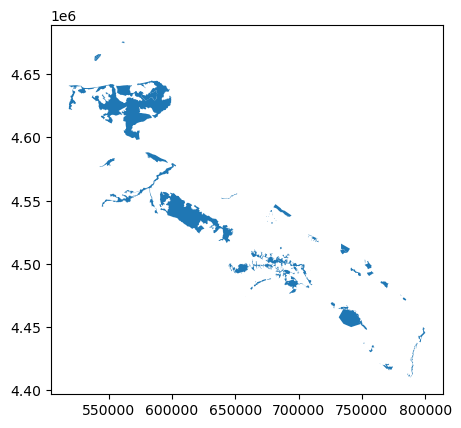

In [19]:
PAs_gdf = gpd.read_file('Data_files/PAs.shp') 

PAs_gdf.plot()

### Clip
Now, we can use our Area of Interest (AOI) shapefile to clip the PAs GeoDataFrame and save it to a new shapefile as below.

<Axes: >

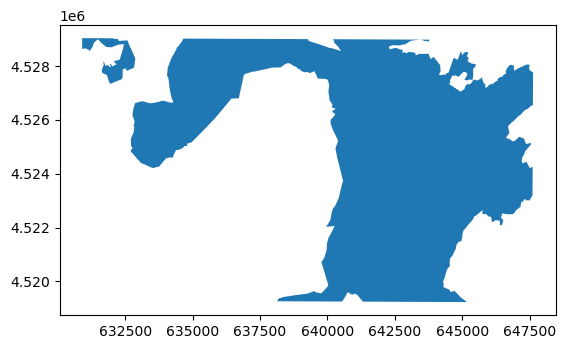

In [20]:
# Load the Area of Interest (AOI) shapefile into a GeoDataFrame
AOI_gdf = gpd.read_file('Data_files/Area_of_interest.shp')

# Clip the PAs by the AOI
clipped_PAs = gpd.clip(PAs_gdf, AOI_gdf)

# Save the clipped GeoDataFrame to a new shapefile
clipped_PAs.to_file('Data_files/Output_files/clipped_PAs.shp')

clipped_PAs.plot()

### Translating Column Titles

Let's examine the new shapefile:

In [22]:
clipped_PAs.head()

,R_LEGISL,RETTIFICHE,DENOM,CLASSIF,CODICEAP,decreto,Pubbl,Area_ha,gestione,MOD_INTEGR,NORMA,NOME_COMUN,CLASSE,geometry
0,L. n. 426 del 09.12.1998,None,Parco nazionale dell'Alta Murgia,Parco Nazionale,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,Ente Parco Nazionale dell' Alta Murgia,aaaaa,None,None,Parchi nazionali e riserve naturali statali,"MULTIPOLYGON (((639301.253 4528924.181, 639908..."


It looks like it has quite a lot of columns, to be able to keep our data tidy, we might decide to delete any unnecessary columns:

In [23]:
# Identify columns to delete from above
columns_to_delete = ['RETTIFICHE', 'MOD_INTEGR', 'NORMA', 'NOME_COMUN', 'CLASSIF']

# Drop the specified columns
clipped_PAs.drop(columns=columns_to_delete, inplace=True)

# Save the modified GeoDataFrame back to a shapefile
output_path = 'Data_files/Output_files/updated_PAs.shp'
clipped_PAs.to_file(output_path)

print(f"Columns {', '.join(columns_to_delete)} have been deleted from the shapefile.")

Columns RETTIFICHE, MOD_INTEGR, NORMA, NOME_COMUN, CLASSIF have been deleted from the shapefile.


In [24]:
# let's load and check the columns in the updated_SAs shapefile
clipped_PAs = gpd.read_file(output_path)
clipped_PAs.columns

Index(['R_LEGISL', 'DENOM', 'CODICEAP', 'decreto', 'Pubbl', 'Area_ha',
       'gestione', 'CLASSE', 'geometry'],
      dtype='object')

Now we have a GeoDataFrame containing only the columns we are interested in. This time we want to translate only the heading of the columns, to better understand which information is contained in our shapefile. The code below creates a dictionary called **translated_columns** where each key is a column title from **clipped_PAs.columns** and its corresponding value is the translated title in English. The third line of the code uses the rename method to update the column titles of clipped_PAs with their English translations. The inplace=True argument means that the changes are made directly to the original GeoDataFrame without creating a new one. To be able to save the table to a new shapefile instead, uncomment the fourth line of the code.

In [35]:
from  deep_translator import GoogleTranslator

# Initialize the translator
translator = GoogleTranslator(source='it', target='en')

# Define columns to translate
translated_columns = {col: translator.translate(col) for col in clipped_PAs.columns}

# Save changes to the original shapefile.
clipped_PAs.rename(columns=translated_columns, inplace=True)

# Save the GeoDataFrame with the translated column titles to a new shapefile, to use this part of the code, uncomment this line.
# clipped_PAs.to_file('Data_files/Output_files/translated_PAs.shp')

# Print a success message
print("The column titles of the clipped_PAs shapefile have been successfully translated from Italian to English.")

The column titles of the clipped_PAs shapefile have been successfully translated from Italian to English.


In [36]:
# let's load again and check the columns of our clipped_PAs shapefile
clipped_PAs.columns

Index(['R_LEGISL', 'NAME', 'CODEAP', 'decree', 'Publ', 'Area_ha', 'management',
       'CLASS', 'geometry'],
      dtype='object')

### Join

We want to join the PAs shapefile to the Agricultural Plots shapefile so as to have a resulting GeoDataFrame retaining the same geometry of the plots, but with information on the PAs they might interesect, if any, and the total area of intersection for each plot. 

<Axes: >

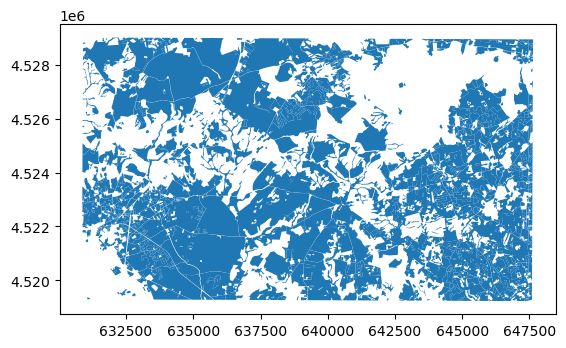

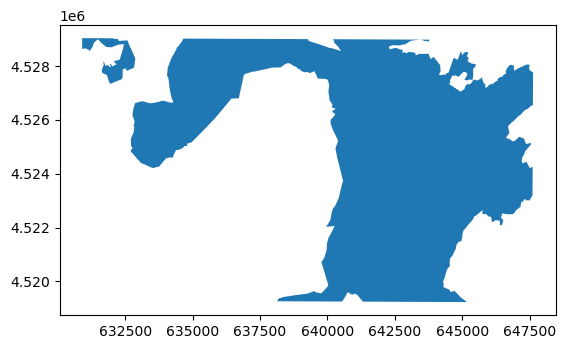

In [37]:
# let's first visualise both shapefiles
gdf.plot()
clipped_PAs.plot()

For our code to run successfully, we need to make a few checks. We need to make sure that:
- the two GeoDataFrame objects have the same CRS
- the PAs shapefile doesn't contain any invalid geometry
- the two GeoDataFrame objects don't have differing geometry types

In [34]:
#we want to check the two GeoDataFrame objects have the same CRS
print(gdf.crs == clipped_PAs.crs)

True


In [38]:
# Check for any invalid geometries
invalid = clipped_PAs[~clipped_PAs['geometry'].is_valid]

# Report if any invalid geometries are found
if not invalid.empty:
    print(f"Found {len(invalid)} invalid geometries.")
else:
    print("No invalid geometries found.")

No invalid geometries found.


In [30]:
# we want to check the geometry type of the two GeoDataFrame objects
print(gdf.geom_type.unique())
print(clipped_PAs.geom_type.unique())

['Polygon' 'MultiPolygon']
['MultiPolygon']


From the cell above we can see that while the Agricultural Plots shapefile has two geometry types (Polygon and MultiPolygon), the PAs shapefile has only the Polygon geometry type. This might bring about errors when we join the two files and try to calculate their intersection area. To fix this, we can use the **unary union** operation from the shapely.ops module to combine all geometry objects in clipped_PAs into a single Multipolygon object. 

In [39]:
from shapely.ops import unary_union
# Convert all geometries in clipped_PAs to a single MultiPolygon
clipped_PAs['geometry'] = [unary_union(clipped_PAs['geometry'])]

# Print success message
print('All geometries in clipped_PAs converted to a single MultiPolygon.')

All geometries in clipped_PAs converted to a single MultiPolygon.


Now that all geometries in clipped_PAs have been converted to a single MultiPolygon, we can perform the spatial join. The code below performs a spatial join between the two GeoDataFrames and calculates the area of intersection (in hectares) between the two sets of geometries. 

In [40]:
join = gpd.sjoin(gdf, clipped_PAs, how='left', predicate='intersects')

# Create a new column and calculate the area of intersection for each row
join['int_ha'] = join.geometry.intersection(clipped_PAs.geometry[0]).area / 10**4 #convert to hectares

# Save the resulting shapefile with the new column
join.to_file('Data_files/Output_files/joined_with_area.shp')

# Print a success message
print("The joined shapefile now includes a column with the area of intersection between Agricultural Plots and Protected Areas")

C:\Users\M533\AppData\Local\Temp\ipykernel_26832\682170603.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  join.to_file('Data_files/Output_files/joined_with_area.shp')


The joined shapefile now includes a column with the area of intersection between Agricultural Plots and Protected Areas


### Shortening Column Names to avoid Truncation

Now, even though the join was run successfully, we still might be getting a warning message about the column names being more than 10 characters long. This will cause them to be truncated when saved to ESRI shapefile. If we want, we can rename columns to ensure they are no longer than 10 characters, using the code below.

In [41]:
shortened_columns = {col: col[:10] for col in join.columns if len(col) > 10}
join.rename(columns=shortened_columns, inplace=True)

# Check for any non-unique column names
if len(join.columns) != len(set(join.columns)):
    raise ValueError("Non-unique column names detected after truncation.")

# Save the joined shapefile with the new column names
join.to_file('Data_files/Output_files/joined_with_area.shp')

# Print a success message
print("The joined shapefile has been saved with shortened column names to avoid truncation.")

The joined shapefile has been saved with shortened column names to avoid truncation.


## Preliminary Analysis
Before proceeding with our analysis, it might be wise to check that we perfomed the join correctly by checking that the joined shapefile still looks like our Agricultural Plot shapefile. 

<Axes: >

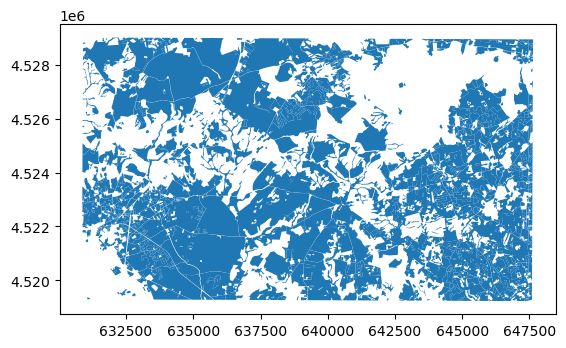

In [38]:
join.plot()

### Sum
Now that we made sure the file looks right we can use the information  obtained so far to perform some calculation. For example, we are interested in knowing the total surface area of intersection between our land plots and PAs.
#### Total Area of Intersection

In [42]:
join['int_ha'].sum()

3766.827773849376

### Group by
Using the groupby function, we can calculate the total count of agricultural plot as well as their surface area per management type.

#### Total Count of Agricultural Plots per Management Type

In [47]:
join.groupby(['DESC_'])['CODICE'].count()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces      1
complex cultivation and parcel systems                                               7
olive groves                                                                       416
orchards and minor fruits                                                          167
other permanent crops                                                                2
simple arable land in non-irrigated areas                                          551
surfaces with dense herbaceous cover                                                12
temporary crops associated with permanent crops                                      7
vineyards                                                                           26
Name: CODICE, dtype: int64

#### Total Surface Area per Management Type

In [44]:
join.groupby(['DESC_'])['Plot_ha'].sum()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces       2.031017
complex cultivation and parcel systems                                                7.260655
olive groves                                                                       1367.652552
orchards and minor fruits                                                           472.013162
other permanent crops                                                                51.782436
simple arable land in non-irrigated areas                                          7498.352693
surfaces with dense herbaceous cover                                                 71.306602
temporary crops associated with permanent crops                                       6.614080
vineyards                                                                            10.084407
Name: Plot_ha, dtype: float64

#### Total Intersection Area per Management Type

In [43]:
join.groupby(['DESC_'])['int_ha'].sum()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces       1.944326
complex cultivation and parcel systems                                                1.584322
olive groves                                                                        590.871879
orchards and minor fruits                                                           346.074383
other permanent crops                                                                51.782436
simple arable land in non-irrigated areas                                          2770.770287
surfaces with dense herbaceous cover                                                  0.002823
temporary crops associated with permanent crops                                       1.297607
vineyards                                                                             2.499710
Name: int_ha, dtype: float64

### Percentages

We can also calculate how much (%) of the Agricutural Plots surface area is interesected by  PAs per Management Type as below.

In [49]:
import numpy as np

numeric_cols = join.select_dtypes(include=[np.number]).columns.tolist()
grouped = join.groupby('DESC_')[numeric_cols].sum()
grouped['percentage'] = (grouped['int_ha'] / grouped['Plot_ha']) * 100
print(grouped['percentage'])

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces     95.731622
complex cultivation and parcel systems                                              21.820648
olive groves                                                                        43.203362
orchards and minor fruits                                                           73.318799
other permanent crops                                                              100.000000
simple arable land in non-irrigated areas                                           36.951720
surfaces with dense herbaceous cover                                                 0.003958
temporary crops associated with permanent crops                                     19.618865
vineyards                                                                           24.787875
Name: percentage, dtype: float64


This is the end of Part 1 of the code. The next Part download Satellite Imagery for the area of interest and calculate NDVI.